<a href="https://colab.research.google.com/drive/1nQwL6i_yp7EhbfFTvP--0N_jOHBNu8Ko?authuser=0#scrollTo=uYebzKd5W3k5" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
mon_features25 = pd.read_csv('/content/drive/MyDrive/ML_2024_2/mon_features25.csv')
mon_label = pd.read_csv('/content/drive/MyDrive/ML_2024_2/mon_label.csv')

unmon_features25 = pd.read_csv('/content/drive/MyDrive/ML_2024_2/unmon_features25.csv')
unmon_label = pd.read_csv('/content/drive/MyDrive/ML_2024_2/unmon_label.csv')

In [ ]:
features25 = pd.concat([mon_features25, unmon_features25], ignore_index=True)
# mon의 label은 1, unmon의 label은 -1
mon_label = np.ones(len(mon_features25))
unmon_label = -np.ones(len(unmon_features25))
label = np.concatenate([mon_label, unmon_label])

In [ ]:
for column in features25.columns:
    if features25[column].apply(lambda x: isinstance(x, str)).any():
        print(f"Column '{column}' contains string data.")
        print("Sample data:", features25[column].iloc[0])

Column 'cumulative_packet_size_seq' contains string data.
Sample data: [-512, -1024, -512, -1024, -512, -1024, -512, 0, -512, -1024, -1536, -2048, -2560, -3072, -3584, -4096, -4608, -5120, -5632, -6144, -6656, -7168, -6656, -7168, -6656, -7168, -7680, -7168, -6656, -6144, -6656, -6144, -6656, -7168, -7680, -7168, -6656, -7168, -6656, -6144, -6656, -7168, -7680, -8192, -8704, -9216, -9728, -10240, -10752, -10240, -10752, -11264, -10752, -11264, -10752, -11264, -11776, -12288, -12800, -13312, -13824, -14336, -14848, -15360, -15872, -16384, -16896, -17408, -17920, -18432, -18944, -19456, -19968, -20480, -20992, -21504, -22016, -22528, -23040, -23552, -24064, -24576, -25088, -25600, -26112, -26624, -27136, -27648, -28160, -28672, -29184, -29696, -30208, -30720, -31232, -31744, -32256, -32768, -33280, -33792, -34304, -34816, -35328, -35840, -36352, -36864, -37376, -37888, -38400, -38912, -39424, -39936, -40448, -40960, -41472, -41984, -42496, -43008, -43520, -44032, -44544, -44032, -44544, 

In [ ]:
# cumulative_packet_size_seq과 burst_seq 드롭
features25 = features25.drop(['cumulative_packet_size_seq', 'burst_seq'], axis=1)

# 드롭 후 데이터 확인
print(features25.head())
print(features25.dtypes)

   num_total_packets  sum_packets  num_incoming_packets  \
0               1421       727552                  1300   
1                518       265216                   438   
2               1358       695296                  1240   
3               1446       740352                  1324   
4               1406       719872                  1291   

   frac_incoming_packets  num_outgoing_packets  frac_outgoing_packets  \
0               0.914849                   121               0.085151   
1               0.845560                    80               0.154440   
2               0.913108                   118               0.086892   
3               0.915629                   122               0.084371   
4               0.918208                   115               0.081792   

   packet_size_ratios  burst_lengths  average_incoming_ordering  \
0            0.093077            156                 704.106154   
1            0.182648             94                 264.406393   
2    

In [ ]:
print(features25.shape)
print(label.shape)

(22000, 23)
(22000,)


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(features25, label, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

###Baseline - SMOTE X

In [ ]:
# SVM 모델 정의 및 학습
svm_model = SVC(probability=True,random_state=42)  # 기본 하이퍼파라미터 사용
svm_model.fit(X_train, y_train)


# 검증 데이터 평가
y_valid_pred = svm_model.predict(X_val)
y_valid_proba = svm_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률

# Accuracy
valid_accuracy = accuracy_score(y_val, y_valid_pred)
print(f'Validation Accuracy: {valid_accuracy:.2f}')

# True Positive Rate (TPR) & False Positive Rate (FPR)
conf_matrix = confusion_matrix(y_val, y_valid_pred)
tn, fp, fn, tp = conf_matrix.ravel()

tpr = tp / (tp + fn)  # True Positive Rate
fpr = fp / (fp + tn)  # False Positive Rate

print(f"True Positive Rate (TPR): {tpr:.2f}")
print(f"False Positive Rate (FPR): {fpr:.2f}")

# Precision & Recall
precision = precision_score(y_val, y_valid_pred)
recall = recall_score(y_val, y_valid_pred)
f1 = f1_score(y_val, y_valid_pred)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# ROC AUC
roc_auc = roc_auc_score(y_val, y_valid_proba)
print(f"ROC AUC: {roc_auc:.2f}")

# Precision-Recall AUC
precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_valid_proba)
pr_auc = auc(recall_vals, precision_vals)
print(f"Precision-Recall AUC: {pr_auc:.2f}")

Validation Accuracy: 0.86
True Positive Rate (TPR): 1.00
False Positive Rate (FPR): 0.99
Precision: 0.86
Recall: 1.00
F1 Score: 0.93
ROC AUC: 0.74
Precision-Recall AUC: 0.93


In [ ]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

###SMOTE O

In [ ]:
# SVM 모델 정의 및 학습
svm_model = SVC(probability=True,random_state=42)  # 기본 하이퍼파라미터 사용
svm_model.fit(X_train_sm, y_train_sm)


# 검증 데이터 평가
y_valid_pred = svm_model.predict(X_val)
y_valid_proba = svm_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률

# Accuracy
valid_accuracy = accuracy_score(y_val, y_valid_pred)
print(f'Validation Accuracy: {valid_accuracy:.2f}')

# True Positive Rate (TPR) & False Positive Rate (FPR)
conf_matrix = confusion_matrix(y_val, y_valid_pred)
tn, fp, fn, tp = conf_matrix.ravel()

tpr = tp / (tp + fn)  # True Positive Rate
fpr = fp / (fp + tn)  # False Positive Rate

print(f"True Positive Rate (TPR): {tpr:.2f}")
print(f"False Positive Rate (FPR): {fpr:.2f}")

# Precision & Recall
precision = precision_score(y_val, y_valid_pred)
recall = recall_score(y_val, y_valid_pred)
f1 = f1_score(y_val, y_valid_pred)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# ROC AUC
roc_auc = roc_auc_score(y_val, y_valid_proba)
print(f"ROC AUC: {roc_auc:.2f}")

# Precision-Recall AUC
precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_valid_proba)
pr_auc = auc(recall_vals, precision_vals)
print(f"Precision-Recall AUC: {pr_auc:.2f}")

Validation Accuracy: 0.70
True Positive Rate (TPR): 0.70
False Positive Rate (FPR): 0.28
Precision: 0.94
Recall: 0.70
F1 Score: 0.80
ROC AUC: 0.78
Precision-Recall AUC: 0.95


### GridSearch

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']}

grid_search_svm = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid_search_svm.fit(X_train_sm, y_train_sm)
print(f"Best Params: {grid_search_svm.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.735 total time=  35.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.760 total time=  35.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.770 total time=  36.7s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.768 total time=  35.8s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.782 total time=  35.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.688 total time=  32.6s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.694 total time=  34.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.714 total time=  35.4s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.693 total time=  33.2s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.704 total time=  33.4s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.632 total time=  35.2s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;

In [ ]:
# SVM 모델 정의 및 학습
svm_model = SVC(kernel='rbf', C=100, gamma=1, probability=True, random_state=42)  # best 하이퍼파라미터 사용
svm_model.fit(X_train_sm, y_train_sm)


# 검증 데이터 평가
y_valid_pred = svm_model.predict(X_val)
y_valid_proba = svm_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률

# Accuracy
valid_accuracy = accuracy_score(y_val, y_valid_pred)
print(f'Validation Accuracy: {valid_accuracy:.2f}')

# True Positive Rate (TPR) & False Positive Rate (FPR)
conf_matrix = confusion_matrix(y_val, y_valid_pred)
tn, fp, fn, tp = conf_matrix.ravel()

tpr = tp / (tp + fn)  # True Positive Rate
fpr = fp / (fp + tn)  # False Positive Rate

print(f"True Positive Rate (TPR): {tpr:.2f}")
print(f"False Positive Rate (FPR): {fpr:.2f}")

# Precision & Recall
precision = precision_score(y_val, y_valid_pred)
recall = recall_score(y_val, y_valid_pred)
f1 = f1_score(y_val, y_valid_pred)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# ROC AUC
roc_auc = roc_auc_score(y_val, y_valid_proba)
print(f"ROC AUC: {roc_auc:.2f}")

# Precision-Recall AUC
precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_valid_proba)
pr_auc = auc(recall_vals, precision_vals)
print(f"Precision-Recall AUC: {pr_auc:.2f}")

Validation Accuracy: 0.84
True Positive Rate (TPR): 0.91
False Positive Rate (FPR): 0.63
Precision: 0.90
Recall: 0.91
F1 Score: 0.91
ROC AUC: 0.74
Precision-Recall AUC: 0.94


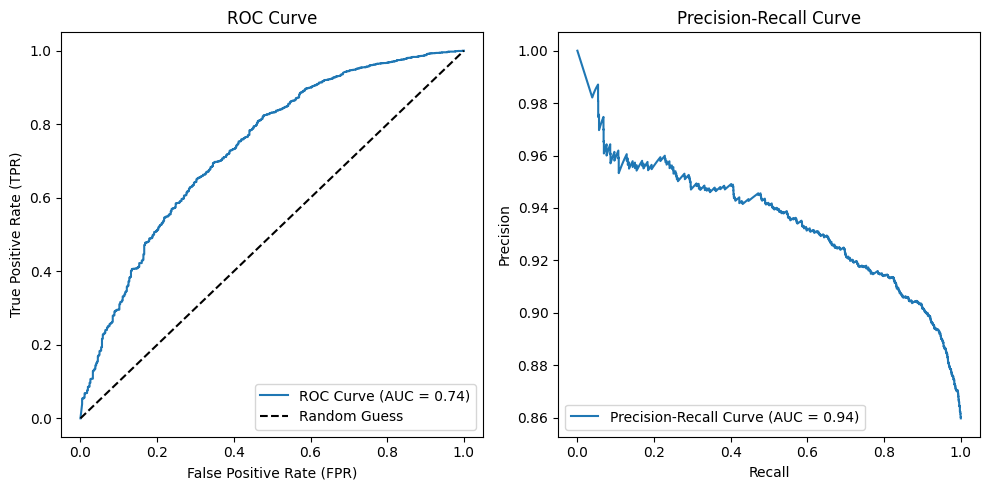

In [ ]:
# ROC Curve
fpr_vals, tpr_vals, _ = roc_curve(y_val, y_valid_proba)
roc_auc = auc(fpr_vals, tpr_vals)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_vals, tpr_vals, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_valid_proba)
pr_auc = auc(recall_vals, precision_vals)

plt.subplot(1, 2, 2)
plt.plot(recall_vals, precision_vals, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

### 최종 성능 평가 - test data 사용

In [ ]:
# 최종 테스트 데이터 평가
y_test_pred = svm_model.predict(X_test)
y_test_proba = svm_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률

# 정확도
accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy: {accuracy:.2f}')